In [34]:
import numpy as np
import matplotlib.pyplot as plt
# add here the libraries you need
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.special import comb

In [35]:
def is_well_defined(transition_matrix):
    """Check if the elements sum up to one for every row"""
    threshold = 1e-10
    num_rows = len(transition_matrix)
    for row in range(num_rows):
        acc = sum(transition_matrix[row, :])
        if abs(acc - 1) > threshold: # return false is a row does not sum up to 1
            return False
    return True

def is_in_0_1(p):
    """Check if p is a vector whose elements are in [0,1]"""
    for prob in p:
        if 0 > prob or 1 < prob:
            return False
    return True

def is_prob_vector(p):
    """Check if p is a vector whose elements are in [0,1] and sum up to one"""
    threshold = 1e-10
    acc = 0
    for prob in p:
        acc += prob
    return abs(acc - 1) < threshold and is_in_0_1(p)

# Discrete Time Markov Chains
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC before attempting to solve it! 

### Models

Consider few DTMCs, those seen in the lectures and few more:

1. A student goes to a concert and alternates between being "dancing" and being "at the bar" until, at a certain point, it goes home which is an absorbing state. Model this scenario as a DTMC, draw the diagram and define the respective transition matrix, called `transition_concert`.  

Give names to states and use a dictionary to match names with indexes in the matrix.


Always check that the defined transition matrix is **well-defined**.

<img src="imgs/party.png" width="300">

In [36]:
transition_concert = np.array([[0,0.9,0.1],[0.9,0,0.1],[0,0,1]])

states = {"dancing" : 0, "at bar" : 1, "at home" : 2}

print("The stocastic matrix is:\n", transition_concert)

print("Is the matrix well defined?", is_well_defined(transition_concert))

p02 = transition_concert[states["dancing"],states["at home"]]
print("Probability to go home after dancing: ", p02)

The stocastic matrix is:
 [[0.  0.9 0.1]
 [0.9 0.  0.1]
 [0.  0.  1. ]]
Is the matrix well defined? True
Probability to go home after dancing:  0.1


2. Consider a walker moving randomly along the star graph shown below. The graph is composed of six states. State 6 is the terminal point. 

<img src="imgs/star_graph.png" width="300">

Model the movement of the walker as a DTMC. Choose the parameters $a,b,c,d,e,f,e\in (0,1)$ so that the transition matrix, `transition_star`, is well-defined.
Keep in mind that, ingoing and outgoing transitions can happen with different probabilities.

In [37]:
def build_walker_matrix(probs):
    """Expects as input a dictionary with the 6 parameters and returns the transition matrix according to 
    the provided diagram"""
    
    assert is_in_0_1(probs.values()), "Probabilities out of bound."
    
    transition_star = np.zeros((6,6))
    
    # Building every node. The indexes are index = node - 1
    # Node 1 (index 0):
    transition_star[0,3] = 1 - probs["a"]
    transition_star[0,4] = probs["a"]
    ##########################################
    # Node 2:
    transition_star[1,5] = probs["b"]
    transition_star[1,2] = probs["c"]
    transition_star[1,4] = 1 - probs["b"] - probs["c"]
    ##########################################
    #Node 3:
    transition_star[2,1] = 1 - probs["d"]
    transition_star[2,3] = probs["d"]
    ##########################################
    # Node 4:
    transition_star[3,0] = probs["e"]
    transition_star[3,2] = 1 - probs["e"]
    ##########################################
    # Node 5:
    transition_star[4,0] = 1 - probs["f"]
    transition_star[4,1] = probs["f"]
    ##########################################
    # Node 6:
    transition_star[5,5] = 1
    ##########################################
    
    return transition_star

d = {"a" : 0.1, "b" : 0.2, "c" : 0.3, "d": 0.4, "e" : 0.5, "f" : 0.6}
transition_star = build_walker_matrix(d)
print("The parameters are: ", d)
print("The corresponding stocastic matrix is:\n", transition_star)

The parameters are:  {'a': 0.1, 'b': 0.2, 'c': 0.3, 'd': 0.4, 'e': 0.5, 'f': 0.6}
The corresponding stocastic matrix is:
 [[0.  0.  0.  0.9 0.1 0. ]
 [0.  0.  0.3 0.  0.5 0.2]
 [0.  0.6 0.  0.4 0.  0. ]
 [0.5 0.  0.5 0.  0.  0. ]
 [0.4 0.6 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1. ]]


3. A general birth-death chain, `transition_birth_death()`. Define it writing a function that takes `N` as input (the maximum population size) and vectors `p` (the birth probability) and `q` (the death probability) of length N and returns the transition matrix `transition_birth_death`.

<img src="imgs/birth-death.png" width="600">

In [38]:
def check_vectors(N,p,q):
    """Function that checks if the vectors for a general birth-death chain of maximum population N are valid"""
    if len(p) != N or len(q) != N: # vectors must be of size N
        return False
    for i in range(N):
        if p[i] + q[i] > 1: # For every state, the sum of the probabilities should not exceed 1
            return False
    return True

def build_transition_birth_death(N, p, q):
    """Function that builds a transition matrix for a general birth-death chain of maximum population N, 
    given the vector of probabilities of birth and death"""
    
    assert check_vectors(N,p,q), "Wrong vectors."
    assert N > 0, "Negative max population"
    
    transition_birth_death = np.zeros((N+1,N+1))
    
    transition_birth_death[0,0] = 1 - p[0]
    transition_birth_death[0,1] = p[0]
    
    for i in range(1,N):
        transition_birth_death[i,i-1] = q[i-1]
        transition_birth_death[i,i+1] = p[i]
        transition_birth_death[i,i] = 1 - p[i] - q[i-1]
        
    transition_birth_death[N,N-1] = q[N-1]
    transition_birth_death[N,N] = 1 - q[N-1]
    
    return transition_birth_death

In [39]:
N = 5
p = np.array([0.2,0.3,0.5,0.6,0.4])
q = np.array([0.6,0.5,0.3,0.2,0.5])

transition_birth_death = build_transition_birth_death(N,p,q)
print("Is the transition matrix well-defined?", is_well_defined(transition_birth_death))
print("The corresponding transition matrix is:")
transition_birth_death

Is the transition matrix well-defined? True
The corresponding transition matrix is:


array([[0.8, 0.2, 0. , 0. , 0. , 0. ],
       [0.6, 0.1, 0.3, 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.3, 0.1, 0.6, 0. ],
       [0. , 0. , 0. , 0.2, 0.4, 0.4],
       [0. , 0. , 0. , 0. , 0.5, 0.5]])

4. **Queue model**. Queuing chains model the number of customers in the system as a function of time, and in particular, whether the server(s) can adequately handle the flow of customers. 
Let $X_n$ be the number of custumers in the system at time $n\in \mathbb{N}$. 
Define a DTMC that models a queueing system where the costumer propensity to join the system, i.e. the arrival rate, is inversely proportional to the current length of the queue.


Draw the transitions graph, the transition matrix and explain the details of your model in the two following scenarios:

4.1. **Single server**: the service is provided by a single server with service rate $\mu$


<img src="imgs/xqueue.png" width="300">


4.2. $m$ **servers**: the service is provided by $m$ servers each with a service rate $\mu$

<img src="imgs/xqueue_m_servers.png" width="300">

### 4.1: 
At every time step, at most one person can be served and at most one can arrive.
#### Arrival distribution
The probability distribution of the arrival of a new person is dependent on the current state of the chain:
$$
p_{X_n} =
\begin{cases}
    Be\left(\frac{1}{X_n}\right), & if \ X_n \geq 2 \\
    1 , & if \ X_n < 2 
\end{cases}
$$
#### Serving distribution
The probability distribution of a person in queue being served depends on the serving rate of the server. If the serving rate is greater than one, for sure one person will be served at each time step (i.e. the queue will not grow).
$$
p_{\mu} =
\begin{cases}
    Be\left(\mu\right), & if \ 0 < \mu < 1\\
    1 , & if \ \mu \geq 1 
\end{cases}
$$
#### Stocastic matrix
Suppose $0 < \mu < 1$. We have that: <br>
<ul>
<li>With probability $ \mu * (1 - \frac{1}{X_n})$ one person is served and no one arrives, i.e. this is $p_{i,i-1}$ <br>
<li>With probability $ (1 - \mu) * \frac{1}{X_n}$ no one is served and one person arrives, i.e. this is $p_{i,i+1}$ <br>
<li>With probability $ p_{i,i} = 1 - p_{i,i+1} - p_{i,i-1}$ the queue size remains the same, i.e. one person arriveS and one is served or no one is served and no one arrives.
</ul>

#### Example: max length = 4
<img src="imgs/single_server.png" width="500">

In [40]:
# Example of with mu = 0.5 and max length of queue = 4
mu = 0.5
max_length = 4
queue_single_server = np.zeros((max_length + 1,max_length + 1))
queue_single_server[0,1] = 1
for state in range(1,max_length):
    queue_single_server[state,state - 1] = mu * (1. - 1./state)
    queue_single_server[state,state + 1] = (1 - mu) * (1./state)
    queue_single_server[state,state] = 1 - queue_single_server[state,state - 1] - queue_single_server[state,state + 1]
queue_single_server[max_length,max_length - 1] = mu * (1. - (1./max_length))
queue_single_server[max_length,max_length] = 1 - queue_single_server[max_length,max_length - 1]

print("Example stocastic matrix for a single server queue with max length = 4, mu = 0.5:")
print("Is it well-defined?", is_well_defined(queue_single_server))
queue_single_server

Example stocastic matrix for a single server queue with max length = 4, mu = 0.5:
Is it well-defined? True


array([[0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.25      , 0.5       , 0.25      , 0.        ],
       [0.        , 0.        , 0.33333333, 0.5       , 0.16666667],
       [0.        , 0.        , 0.        , 0.375     , 0.625     ]])

### 4.2
At every time step at most one person can enter the queue, but at most $m$ people can be served, each with probability $\mu$. We have that:<br>
<ul>
<li>The probability that no one is served and one person arrives is $p_{i,i+1} = (1 - \mu)^m * \frac{1}{X_n}$
<li>The probability to reduce the queue by $k < m$ is the probability of $k$ people being served and no one arrives plus the probability that $k+1$ people being served and one person arrives, i.e. $p_{i,i-k} = {m\choose k} * \mu^k * (1 - \mu)^{m - k} * \left(1-\frac{1}{X_n}\right) + {m\choose k + 1} * \mu^{k+1} * (1 - \mu)^{m-k-1} * \frac{1}{X_n}$
<li>The probability to reduce the queue by $m$ is the probability that no one arrives and $m$ people are served, i.e. $p_{i,i-m} = \mu^m * \left(1 - \frac{1}{X_n}\right)$
<li>The probability that the size of the queue does not change is $p_{i,i} = 1 - p_{i,i+1} - \sum_{k=1}^m p_{i,i-k}$
</ul>

#### Example: max length = 6, m = 2
<img src="imgs/multiple_server.png" width="600">

In [41]:
# Example of with mu = 0.5, max length of queue = 16, m = 4
mu = 0.5
max_length = 8
m = 3
queue_multiple_server = np.zeros((max_length + 1,max_length + 1))
queue_multiple_server[0,1] = 1
for state in range(1,max_length+1):
    if state != max_length:
        queue_multiple_server[state,state + 1] = (1. - mu)**m * (1./state)
    for k in range(1,m):
        if state - k < 0:
            break;
        queue_multiple_server[state,state - k] = comb(m,k)   * mu**k     * (1. - mu)**(m-k)   * (1. - (1./state)) + \
                                                 comb(m,k+1) * mu**(k+1) * (1 - mu) **(m-k-1) *(1./state)
    if state - m >= 0:
        queue_multiple_server[state,state - m] = mu**m * (1. - (1./state))
    acc = 0
    queue_multiple_server[state,state] = 1 - sum(queue_multiple_server[state,:])
    
print("Is the stocastic matrix well defined? ", is_well_defined(queue_multiple_server))
print("Example stocastic matrix for a multiple server queue with max length = 8, mu = 0.5 and m = 3:")
queue_multiple_server

Is the stocastic matrix well defined?  True
Example stocastic matrix for a multiple server queue with max length = 8, mu = 0.5 and m = 3:


array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.375     , 0.5       , 0.125     , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.25      , 0.375     , 0.3125    , 0.0625    , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.08333333, 0.29166667, 0.375     , 0.20833333, 0.04166667,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.09375   , 0.3125    , 0.375     , 0.1875    ,
        0.03125   , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.1       , 0.325     , 0.375     ,
        0.175     , 0.025     , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.10416667, 0.33333333,
        0.375     , 0.16666667, 0.02083333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.10714286,
        0.33928571, 0.375     , 0.16071429, 0.01785714],


### Transient probability
Write a function that takes a DTMC as input (both the transition matrix `transition_model` and the initial probability `prob_init_model`) and the number of steps `n`, and returns the probability `prob_model` of being in each state after `n` steps. Plot the output as an histogram. 
*Extra*: compute the transient probabilities from time 0 to time `n` and visualize this output as a 2d colormap, with one axis representing states, and the other time. 


After 5 steps: [0.2657205 0.2657205 0.468559 ]


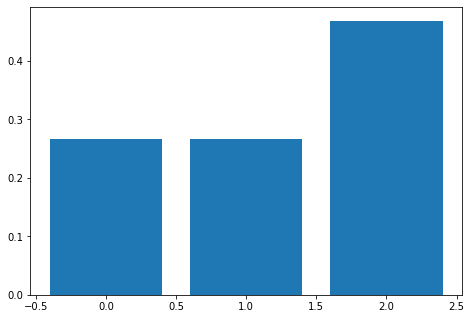

Probabilities from 0 to 10 steps:


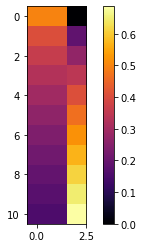

array([[0.5       , 0.5       , 0.        ],
       [0.405     , 0.405     , 0.19      ],
       [0.3645    , 0.3645    , 0.271     ],
       [0.32805   , 0.32805   , 0.3439    ],
       [0.295245  , 0.295245  , 0.40951   ],
       [0.2657205 , 0.2657205 , 0.468559  ],
       [0.23914845, 0.23914845, 0.5217031 ],
       [0.21523361, 0.21523361, 0.56953279],
       [0.19371024, 0.19371024, 0.61257951],
       [0.17433922, 0.17433922, 0.65132156],
       [0.1569053 , 0.1569053 , 0.6861894 ]])

In [42]:
def prob_n_steps(transition_model, prob_init_model, n):
    """Function that computes the vector of probability for a DTMC after n steps."""
    assert n >= 0, "Negative number of steps provided"
    if(n == 0):
        return prob_init_model
    trans_n = transition_model
    for i in range(n):
        trans_n = np.matmul(trans_n,transition_model)
    n_steps = np.matmul(prob_init_model, trans_n)   
    return n_steps

# Extra:
def from_0_to_n(transition_model, prob_init_model, n):
    num_states = len(transition_model)
    matrix = np.zeros((n+1, num_states))
    for i in range(0,n+1):
        matrix[i,:] = prob_n_steps(transition_model,prob_init_model,i)

    plt.imshow(matrix,cmap="inferno")
    plt.colorbar()
    plt.show()
    
    return matrix
    
prob_init_model = np.array([0.5,0.5,0.])
n = 5
n_steps = prob_n_steps(transition_concert, prob_init_model, n)

print("After 5 steps:",n_steps)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
states = range(0,transition_concert.shape[0])
ax.bar(states,n_steps)
plt.show()

print("Probabilities from 0 to 10 steps:")
from_0_to_n(transition_concert, prob_init_model, 10)


### Reachability (absorption probability) and hitting times.
Write a function that takes as input:
- a DTMC (the transition matrix `transition_model` is enough),
- a subset of states `target_region` (either specified by their name or by their indices).
The function should compute a vector `prob_absorption_model`, containing the **absorption probability** for each state. Use the iterative method discussed in the lecture. 

Implement also a method with the same input, returning the **expected hitting times** `exp_hitting_time_model`.

In [43]:
def absortion_prob(transition_model, target_region):
    """Function that computes the absortion probability vector of a subset of states."""
    threshold = 1e-15
    n = len(transition_model)
    abs_matrix = np.copy(transition_model)

    for state in target_region:
        abs_matrix[state,:] = np.zeros(n)
        abs_matrix[state,state] = 1.
    
    h_prec = np.zeros(n)
    h_prec[target_region] = 1.
    h_cur  = np.matmul(abs_matrix,h_prec) 
    
    while np.linalg.norm(h_cur-h_prec) > threshold:
        h_prec = h_cur
        h_cur  = np.matmul(abs_matrix,h_prec)
        
    return h_cur

# I was not able to figure out an iterative algorithm for the expected hitting times
def exp_hitting_time_model(transition_model, target_region):
    """Function that computes expected hitting time by solving a linear system"""
    hit_matrix = -1 * np.copy(transition_model)
    for state in target_region:
        hit_matrix[state,:] = np.zeros(len(hit_matrix))
    np.fill_diagonal(hit_matrix, 1)
    b = np.ones(hit_matrix.shape[0])
    b[target] = 0
    exp_times = np.linalg.solve(hit_matrix,b)
    return exp_times

states = {"dancing" : 0, "at bar" : 1, "at home" : 2}
target = np.array([states["at home"]])

absortion_concert = absortion_prob(transition_concert,target)
expected_hitting_times = exp_hitting_time_model(transition_concert,target)

print("In respect with the transition matrix describing a student to a concert,")
print("Absortion probability of being at home: ", absortion_concert)
print("Expected hitting time of being at home: ", expected_hitting_times)

In respect with the transition matrix describing a student to a concert,
Absortion probability of being at home:  [1. 1. 1.]
Expected hitting time of being at home:  [10. 10.  0.]


### Steady state probability

Write a function taking as input a DTMC and computes its steady state probability, assuming the chain is irreducible, aperiodic, and finite. 
*Extra*: explore Python libraries and find one implementing graph algorithms. Use a method to compute strongly connected components to check if a chain is irreducible. 

If a chain is not irreducible, feel free to make it reducible adding transitions where needed.

In [44]:
def make_irreducible(transition_model):
    """Takes a stocastic matrix and makes it irreducible"""
    matrix = transition_model
    n_components, labels = connected_components(csgraph=matrix, directed=True, return_labels=True, connection='strong')
    # labels is an array which labels every state according to its strongly connected components 
    # (e.g. every state that belongs to a strongly connected component is labeled with the same number)
    while n_components > 1:
        first = labels[0]
        for i in range(len(labels)):
            if labels[i] != first: # search the first state that is in a different component
                index_1 = 0
                index_2 = i
                for k in range(2):
                    if matrix[index_1,index_2] == 0: # if there is no connection between state 0 and state i
                        for j in range(len(matrix)):
                            if matrix[index_1,j] > 0.1: # search the first connection that is > 0.1
                                matrix[index_1,j] -= 0.05 # reduce it by 0.05. This is to preserve the well definition of the matrix
                                break
                        matrix[index_1,index_2] = 0.05 # add a connection
                    index_1 = i
                    index_2 = 0 # switch the indexes, so to create a connection between i and 0, if it does not exist
                break
        n_components, labels = connected_components(csgraph=matrix, directed=True, return_labels=True, connection='strong')
    return matrix

In [45]:
def steady_state_probability(transition_model):
    """Function that computes the invariant measure for an irreducible DTMC"""
    n = len(transition_model)
    transition_model = make_irreducible(transition_model)
    sys_matrix = np.transpose(np.copy(transition_model)) - np.eye(n)
    sys_matrix = np.insert(sys_matrix, n, [np.ones(n)], axis = 0)
    b = np.zeros(n + 1)
    b[n] = 1
    probs = np.linalg.solve(np.matmul(sys_matrix.T,sys_matrix),np.matmul(sys_matrix.T,b))
    return probs

probs = steady_state_probability(transition_star)
print("Is the computed vector a probability vector?", is_prob_vector(probs))
print("Invariant measure for the walker matrix (exercise 2):", probs)

Is the computed vector a probability vector? True
Invariant measure for the walker matrix (exercise 2): [0.1176762  0.09383129 0.09770222 0.13910566 0.05868327 0.49300136]


#### Model class

Implement a class having all the methods to initialize a DTMC, to compute transient behaviour, steady state behaviour, and reachability. Consider also defining a map linking state numbers to reference meaningful names.

In [46]:
class DTMC:
    """A class that implements the concept of DTMCs."""
    def __init__(self, stoc_matrix, p0, dic = None):
        """Constructor of the class; takes as arguments the stocastic matrix, the initial probabilty vector and an
        optional dictionary to map state numbers to meaningful names. If no dictionary is given, a default 
        mapping (e.g. "State 0" : 0) is constructed."""
        self.stoc_matrix = stoc_matrix
        self.p0 = p0
        
        if(dic is None):
            self.dic = {}
            for i in range(len(p0)):
                name = "State " + str(i)
                self.dic[name] = i
        else:
            self.dic = dic
    
    def transient(self, n):
        """Computes the probability of being in each state after n steps"""
        return prob_n_steps(self.stoc_matrix, self.p0, n)
    
    def steady_state(self):
        """Computes the invariant measure of the matrix"""
        return steady_state_probability(self.stoc_matrix)
    
    def reach(self, states_subset):
        """Computes the absortion probabilities of the given set of states"""
        return absortion_prob(self.stoc_matrix, states_subset)
    
    def hitting_time(self, states_subset):
        """Computes the expected hitting time for the given set of states"""
        return exp_hitting_time_model(self.stoc_matrix, states_subset)

In [47]:
initial_prob_vector = np.array([0.2, 0.3, 0.5, 0, 0, 0])
dic = {"No one" : 0, "One" : 1, "Two" : 2, "Three" : 3, "Four" : 4}

dtmc = DTMC(transition_birth_death,initial_prob_vector, dic)

print("Stocastic matrix: \n", dtmc.stoc_matrix, "\n")
print("Transient probability after 10 steps: ", dtmc.transient(10))
print("Invariant measure: ", dtmc.steady_state())
print("Absortion probability of reaching at 4 individuals: ", dtmc.reach([dtmc.dic["Four"]]))

print("\n-----------------------------------------------------------------------------\n")

initial_prob_vector = np.array([0.5, 0.5, 0])
dic = {"Dancing" : 0, "At bar" : 1, "At home" : 2}

dtmc = DTMC(transition_concert, initial_prob_vector, dic)

print("Stocastic matrix: \n", dtmc.stoc_matrix, "\n")
print("Transient probability after 10 steps: ", dtmc.transient(10))
print("Invariant measure: ", dtmc.steady_state())
print("Absortion probability of going home: ", dtmc.reach([dtmc.dic["At home"]]))

Stocastic matrix: 
 [[0.8 0.2 0.  0.  0.  0. ]
 [0.6 0.1 0.3 0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.3 0.1 0.6 0. ]
 [0.  0.  0.  0.2 0.4 0.4]
 [0.  0.  0.  0.  0.5 0.5]] 

Transient probability after 10 steps:  [0.43367214 0.13300035 0.06137502 0.07172733 0.1711778  0.12904737]
Invariant measure:  [0.27272727 0.09090909 0.05454545 0.09090909 0.27272727 0.21818182]
Absortion probability of reaching at 4 individuals:  [1. 1. 1. 1. 1. 1.]

-----------------------------------------------------------------------------

Stocastic matrix: 
 [[0.  0.9 0.1]
 [0.9 0.  0.1]
 [0.  0.  1. ]] 

Transient probability after 10 steps:  [0.1569053 0.1569053 0.6861894]
Invariant measure:  [0.1754386  0.15789474 0.66666667]
Absortion probability of going home:  [1. 1. 1.]


### Summary exercise
#### Small Monopoly: 

The game Small Monopoly is played on a
game board that has 16 spaces arranged around the outside of a square. The squares
have names like Reading Railroad and Park Place but we will number the squares
0 (Go), 1 (Baltic Avenue), ..., 15 (Boardwalk). You roll two dice
and move forward a number of spaces equal to the sum. The game ends when you reach or pass Boardwalk.

- Square 12 is “Go to Jail,” which sends you to square 4. If you roll a double, you get out.
- There are two Chance squares at 2 and 10 (diamonds on the graph) where you
draw a card, which can send you to another square. The card is picked (with replacement) from a deck containing all the 16 squares.

- Described this game as a directed graph, i.e. define its transition matrix.
- What is the probability of ending the game?
- How long does a game take on average?

<img src="imgs/monopoly.png" width="300">

In [48]:
# There are 16 states. It is assumed that if a player is in prison and rolls a double, he will move forward 
# a number of spaces equal to the double.

monopoly_matrix = np.zeros([16,16])

# Probabilities from state 0:
monopoly_matrix[0,:] = [0,0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,4/36,3/36,2/36,1/36,0,0,0]

# Probabilities from state 1:
monopoly_matrix[1,:] = [0,0,0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,4/36,3/36,2/36,1/36,0,0]

# Probabilities from state 2: equal probability to pick any square
monopoly_matrix[2,:] = [1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16]

# Probabilities from state 3:
monopoly_matrix[3,:] = [0,0,0,0,0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,4/36,3/36,2/36,1/36]

# Probabilities from state 4: if a player rolls a double, he can exit, otherwise he stays in prison
monopoly_matrix[4,:] = [0,0,0,0,30/36,0,1/36,0,1/36,0,1/36,0,1/36,0,1/36,1/36]

# Probabilities from state 5:
monopoly_matrix[5,:] = [0,0,0,0,0,0,0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,4/36,6/36]

# Probabilities from state 6:
monopoly_matrix[6,:] = [0,0,0,0,0,0,0,0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,10/36]

# Probabilities from state 7:
monopoly_matrix[7,:] = [0,0,0,0,0,0,0,0,0,1/36,2/36,3/36,4/36,5/36,6/36,15/36]

# Probabilities from state 8:
monopoly_matrix[8,:] = [0,0,0,0,0,0,0,0,0,0,1/36,2/36,3/36,4/36,5/36,21/36]

# Probabilities from state 9:
monopoly_matrix[9,:] = [0,0,0,0,0,0,0,0,0,0,0,1/36,2/36,3/36,4/36,26/36]

# Probabilities from state 10: equal probability to pick any square
monopoly_matrix[10,:] = [1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16]

# Probabilities from state 11:
monopoly_matrix[11,:] = [0,0,0,0,0,0,0,0,0,0,0,0,0,1/36,2/36,33/36]

# Probabilities from state 12: go to jail
monopoly_matrix[12,:] = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]

# Probabilities from state 13:
monopoly_matrix[13,:] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

# Probabilities from state 14:
monopoly_matrix[14,:] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

# Probabilities from state 15:
monopoly_matrix[15,:] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

initial_probability_vector = np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [49]:
# We will use the DTMC class defined above
small_monopoly = DTMC(monopoly_matrix,initial_probability_vector)

# What is the probability of ending the game?
# It is the absortion probability of being in state 15, starting from state 0.
ending_game = np.array([15]) 
absortion_probability_15 = small_monopoly.reach(ending_game)
prob_ending_game = absortion_probability_15[0]

print("The probability of ending the game is: ", prob_ending_game)

#How long does a game take on average?
# It is the expected hitting time of state 15 starting from 0

expected_hitting_time_15 = small_monopoly.hitting_time(ending_game)
hitting_time_from_start = expected_hitting_time_15[0]

print("The game will take on average ", hitting_time_from_start, " steps.")

The probability of ending the game is:  0.9999999999999987
The game will take on average  3.648049919439909  steps.
